In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-17 17:37:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-17 17:37:23 (5.35 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



## 1. Load the Dataset

In [3]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [13]:
# fetch the categorical and numerical cols
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include='number').columns

In [14]:
print(cat_cols)
print(num_cols)

Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')
Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')


In [18]:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0
df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [19]:
df.isnull().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


## 2. Splitting the data into train, valid, test

In [63]:
# the converted column is our target
X = df.drop(columns='converted')
y = df['converted']
X.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94
1,social_media,retail,1,46992.0,employed,south_america,1,0.80
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87
4,referral,education,3,85012.0,self_employed,europe,3,0.62


In [59]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=1)

len(X_train) + len(X_val) + len(X_test) == len(X)

True

## 3. Analysis


### 1. ROC AUC feature importance

In [60]:
# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
# Use the training dataset for that

from sklearn.metrics import roc_auc_score
mpp = {}
for col in ['lead_score', 'number_of_courses_viewed','interaction_count','annual_income']:
    score = roc_auc_score(y_true=y_train, y_score=X_train[col])
    if score < 0.5:
       score = roc_auc_score(y_true=y_train, y_score=-X_train[col])

    mpp[col] = score

mpp

{'lead_score': np.float64(0.6111168681007025),
 'number_of_courses_viewed': np.float64(0.7652439024390244),
 'interaction_count': np.float64(0.7271914132379249),
 'annual_income': np.float64(0.5446354552990968)}

So, `number of courses viewed` has been able to classify 0/1 i.e `converted` the highest among others.

###2. Training the model

In [61]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression

from sklearn.feature_extraction import DictVectorizer

# Convert your dataframes to list-of-dicts format
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')
test_dicts = X_test.to_dict(orient='records')

# fit dict vectorizer on training data only
dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(train_dicts)

# Transform validation and test data (don’t fit again)
X_val_enc = dv.transform(val_dicts)
X_test_enc = dv.transform(test_dicts)

In [64]:
# Train the logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

# we will get the raw probs [P(0), P(1)] for each training example but only P(1) here
# predict_proba gives the model’s estimated probability of each class.
y_score = model.predict_proba(X_val_enc)[:, 1]
score = roc_auc_score(y_true=y_val, y_score=y_score)
print(f"AUC Score of the model: {score:.3f}")

AUC Score of the model: 0.794


The AUC score of the model comes out to be `0.79`.

### 3.  Precision and Recall

Here, we'll try different thresholds because we only get raw probs from the model and it just converts any `prob > 0.5` to be 1, but we may tryy different threshold vaues which will only give o/p `1` if P(1) > threshold otherwise `0`.... We will check for which threshold value model is feasible from the precision and recall perspective.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


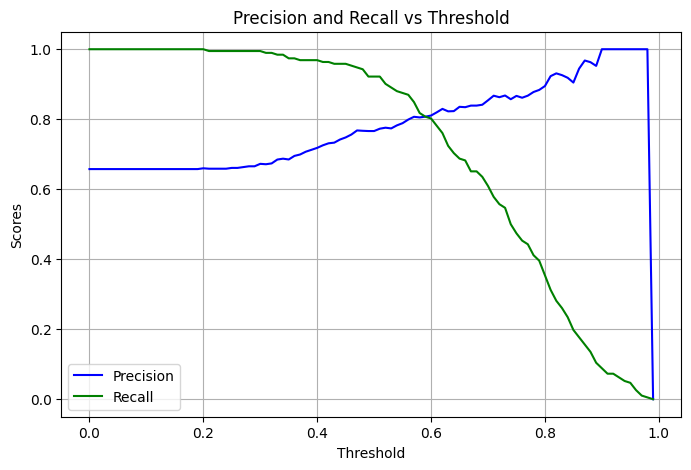

In [68]:
from sklearn.metrics import precision_score, recall_score
# Precision is out of all the model predicted True is actually True.
# Recall is out of all the actual Trues, how many the model actually classified True
threshold = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []

for t in threshold:
    y_preds = (y_score >= t).astype(int)
    precisions.append(precision_score(y_true=y_val, y_pred=y_preds))
    recalls.append(recall_score(y_true=y_val, y_pred=y_preds))


# Plot the precisions and recalls
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(threshold, precisions, label='Precision', color='blue')
ax.plot(threshold, recalls, label='Recall', color='green')
ax.set_xlabel("Threshold")
ax.set_ylabel("Scores")
ax.set_title('Precision and Recall vs Threshold')
ax.legend()
ax.grid(True)

plt.show();

Clearly, there are intersecting around the 0.6 threshold

###4. F1 Score

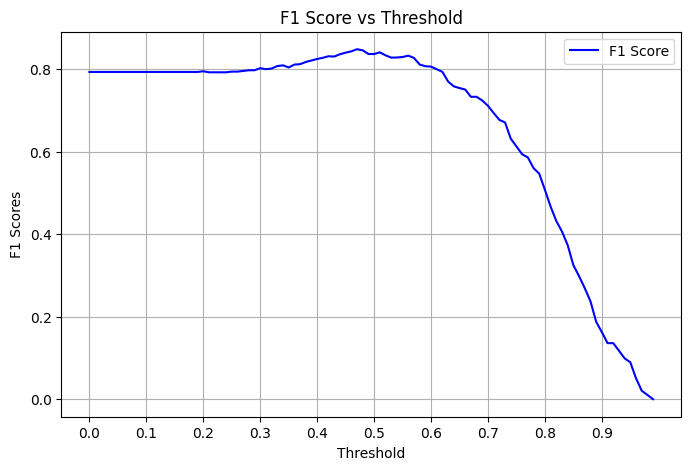

In [84]:
from sklearn.metrics import f1_score
# f1 score combines both precision and recall, formula: (2*precision*recall) / (precision + recall)

threshold = np.arange(0.0, 1.0, 0.01)
f1 = []

for t in threshold:
    y_preds = (y_score >= t).astype(int)
    score = f1_score(y_true=y_val, y_pred=y_preds)
    f1.append(score)

# Plot the precisions and recalls
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(threshold, f1, label='F1 Score', color='blue')
ax.set_xlabel("Threshold")
ax.set_ylabel("F1 Scores")
ax.set_title('F1 Score vs Threshold')
ax.set_xticks(np.arange(0, 1, 0.1))
ax.legend()
ax.grid(True)

plt.show();

In [88]:
best_thres = threshold[np.argmax(f1)]
print(round(best_thres, 3))

0.47


The max F1 score is around **0.85** which lies between threshold values `0.4` and `0.5`.

###5. K-Fold CV

In [98]:
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds

from sklearn.model_selection import KFold

X_full = X_train_enc
y_full = y_train.to_numpy() # for easy indexing

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idxs, valid_idxs in kf.split(X_full):
    # get the train and validation data
    X_train_fold, X_val_fold = X_full[train_idxs], X_full[valid_idxs]
    y_train_fold, y_val_fold = y_full[train_idxs], y_full[valid_idxs]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    y_val_preds = model.predict_proba(X_val_fold)[:, 1]
    score = roc_auc_score(y_val_fold, y_val_preds)

    auc_scores.append(score)


print(f"AUC Scores: {auc_scores}")
print(f"Mean AUC Score: {np.mean(auc_scores):.3f}")
print(f"Std Dev of AUC across different folds: {np.std(auc_scores):.3f}")



AUC Scores: [np.float64(0.8117296491940945), np.float64(0.8232421875), np.float64(0.8364), np.float64(0.8392292205924646), np.float64(0.8282666666666666)]
Mean AUC Score: 0.828
Std Dev of AUC across different folds: 0.010


The standard deviation across scores is `0.010`.

###6. Hyperparameter Tuning

In [101]:
# Now let's use 5-Fold cross-validation to find the best parameter C

from sklearn.model_selection import KFold

X_full = X_train_enc
y_full = y_train.to_numpy() # for easy indexing

kf = KFold(n_splits=5, shuffle=True, random_state=1)
res = []

for c in [0.000001, 0.001, 1]:
    aucs = []
    for train_idxs, valid_idxs in kf.split(X_full):
        # get the train and validation data
        X_train_fold, X_val_fold = X_full[train_idxs], X_full[valid_idxs]
        y_train_fold, y_val_fold = y_full[train_idxs], y_full[valid_idxs]

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        y_val_preds = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_val_preds)

        aucs.append(score)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    res.append((c, mean_auc, std_auc))

print(f"AUC Scores:")
res

AUC Scores:


[(1e-06, np.float64(0.5483516495066526), np.float64(0.04195015614794382)),
 (0.001, np.float64(0.8723218063593279), np.float64(0.015775289071289396)),
 (1, np.float64(0.8277735447906454), np.float64(0.00983698319149229))]

Clearly, at `C=0.001`, the max mean AUC score of `0.872` is obtained.

# Homework 4 - Lead Scoring (Bank Marketing) Summary

**Q1 - Best numerical feature:** `number_of_courses_viewed`  

**Q2 - Validation AUC:** `0.794`  

**Q3 - Threshold where precision ≈ recall:** `0.59`  

**Q4 - Threshold with max F1:** `0.47`  

**Q5 - Standard deviation of AUC across 5 folds:** `0.010`  

**Q6 - Best regularization parameter C:** `0.001`  

---

## Conclusion & Lessons Learned

- Feature importance analysis using ROC AUC can reveal which numerical features contribute most to predictions.  
- Logistic regression with proper one-hot encoding gives a strong baseline for lead scoring, achieving a solid validation AUC.  
- Precision, recall, and F1 curves help in selecting an optimal decision threshold depending on business goals.  
- Cross-validation ensures the model's performance is stable and not dependent on a single train/validation split.  
- Hyperparameter tuning (C in logistic regression) can improve model performance and reduce overfitting.  

Overall, combining feature analysis, threshold tuning, and cross-validation provides a robust approach to building reliable classification models.
